In [1]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import gc

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

from openTSNE import TSNE, affinity

import matplotlib.pyplot as plt
import matplotlib

import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [2]:
torch.__version__

'1.8.1+cu111'

In [3]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import train_loop
from text_embeddings_src.data_stuff import (
    SentencePairDataset,
    MultSentencesPairDataset,
)
from text_embeddings_src.metrics import knn_accuracy
from text_embeddings_src.embeddings import generate_embeddings

In [4]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [5]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [6]:
plt.style.use("matplotlib_style.txt")

In [7]:
model = None
gc.collect()
torch.cuda.empty_cache()

# Import

## Data

In [8]:
%%time
compression_opts = dict(method="zip", archive_name="iclr.pickle.csv")

iclr = pd.read_pickle(
    data_path / "iclr.pickle.zip",
    # index_col=False,
    compression=compression_opts,
)

CPU times: user 174 ms, sys: 30 ms, total: 204 ms
Wall time: 244 ms


In [9]:
iclr

,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,2018,ryBnUWb0b,Predicting Floor-Level for 911 Calls with Neur...,"In cities with tall buildings, emergency respo...","William Falcon, Henning Schulzrinne",Accept (Poster),"[7, 6, 6]","[recurrent neural networks, rnn, lstm, mobile ...",male,None,2.536470,0.739367
1,2018,Skk3Jm96W,Some Considerations on Learning to Explore via...,We consider the problem of exploration in meta...,"Bradly Stadie, Ge Yang, Rein Houthooft, Xi Che...",Invite to Workshop Track,"[7, 4, 6]","[reinforcement learning, rl, exploration, meta...",male,male,49.831927,-29.813831
2,2018,r1RQdCg0W,MACH: Embarrassingly parallel $K$-class classi...,We present Merged-Averaged Classifiers via Has...,"Qixuan Huang, Anshumali Shrivastava, Yiqiu Wang",Reject,"[6, 6, 6]","[extreme classification, large-scale learning,...",None,None,-22.502752,9.577367
3,2018,rJ3fy0k0Z,Deterministic Policy Imitation Gradient Algorithm,The goal of imitation learning (IL) is to enab...,"Fumihiro Sasaki, Atsuo Kawaguchi",Reject,"[6, 5, 5]",[imitation learning],None,None,40.437523,-47.690889
4,2018,SkBYYyZRZ,Searching for Activation Functions,The choice of activation functions in deep net...,"Prajit Ramachandran, Barret Zoph, Quoc V. Le",Invite to Workshop Track,"[5, 4, 7]","[meta learning, activation functions]",None,None,-33.260086,-4.038115
...,...,...,...,...,...,...,...,...,...,...,...,...
16531,2023,w4eQcMZsJa,Text-Driven Generative Domain Adaptation with ...,Combined with the generative prior of pre-trai...,"Zhenhuan Liu, Liang Li, Jiayu Xiao, Zhengjun Z...",Desk rejected,[],"[gan, stylegan, clip, domain adaptation, style...",None,None,59.296526,5.206691
16532,2023,SDHSQuBpf2,"Laziness, Barren Plateau, and Noises in Machin...",We define \emph{laziness} to describe a large ...,"Zexi Lin, Liang Jiang",Desk rejected,[],"[theoretical issues in deep learning, learning...",None,male,-29.178083,-21.810583
16533,2023,HyIY8u5LVDr,Discovering the Representation Bottleneck of G...,Most graph neural networks (GNNs) rely on the ...,"Fang Wu, Siyuan Li, Lirong Wu, Dragomir Radev,...",Desk rejected,[],"[gnn bottleneck, graph rewiring, representatio...",None,male,-7.573978,68.386671
16534,2023,470wZ5Qk4ur,Results for Perfect Classification for Graph A...,We study the ability of one layer Graph Attent...,"Kimon Fountoulakis, Amit Levi",Desk rejected,[],[],None,male,-7.753593,60.764583


In [10]:
titles_abstracts_together = [
    iclr.title[i] + " " + iclr.abstract[i] for i in range(len(iclr))
]

In [11]:
print(len(titles_abstracts_together))

16536


## Labels

In [12]:
# iclr = pd.read_pickle("iclr.pickle.zip")

keywords = [
    "network",
    "graph",
    "reinforcement",
    "language",
    "adversarial",
    "federated",
    "contrastive",
    "domain",
    "diffusion",
    "out-of-dis",
    "continual",
    "distillation",
    "architecture",
    "privacy",
    "protein",
    "fair",
    "attention",
    "video",
    "meta-learning",
    "generative adv",
    "autoencoder",
    "game",
    "semi-sup",
    "pruning",
    "physics",
    "3d",
    "translation",
    "optimization",
    "recurrent",
    "word",
    "bayesian",
]
keywords = np.array(keywords)

y = np.zeros(iclr.shape[0]) * np.nan

for num, keyword in enumerate(keywords):
    mask = [keyword.lower() in t.lower() for t in iclr.title]
    y[mask & ~np.isnan(y)] = -1
    y[mask & np.isnan(y)] = num

print(y.size)
print(np.sum(~np.isnan(y)))
print(np.sum(y >= 0))

labeled = y >= 0

iclr_labeled = iclr[labeled].reset_index(drop=True)
y_labeled = y[labeled].astype(int)
iclr_labeled["y"] = y_labeled
iclr_labeled["label"] = keywords[y_labeled]

16536
8964
6849


## Training

In [13]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

# Check if reproducibility works

## Run 1

In [ ]:
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Set the random seed for NumPy
np.random.seed(seed)

# Set the random seed
random.seed(seed)

In [ ]:
# initialize
i = 0

# random_state = random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased


In [ ]:
training_dataset = SentencePairDataset(
    iclr.abstract,
    tokenizer,
    device,
    seed=seed,
)

In [ ]:
gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=128, shuffle=True, generator=gen
)

In [ ]:
%%time
losses_1, knn_accuracies_1 = train_loop(
    model,
    training_loader,
    device,
    titles_abstracts_together,
    tokenizer,
    labeled,
    labels_acc=iclr_labeled["y"].to_numpy(),
    n_epochs=2,
    lr=2e-5,
)

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Text(0, 0.5, 'kNN accuracy [AV]')

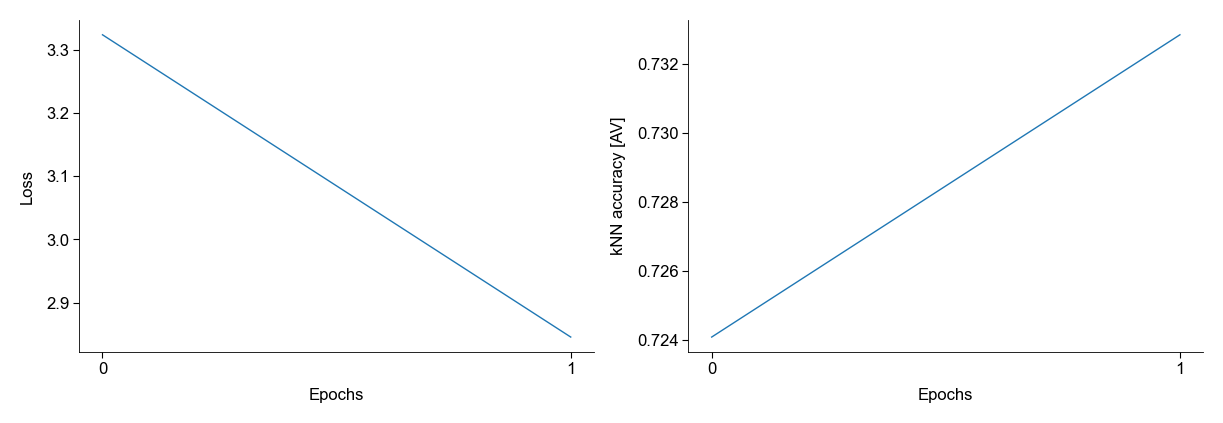

In [ ]:
%matplotlib inline
n_epochs = 2

fig, ax = plt.subplots(1, 2, figsize=(6, 2), dpi=200)

ax[0].plot(np.arange(n_epochs), np.mean(losses_1, axis=1))
ax[0].set_xticks(np.arange(n_epochs))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(np.arange(n_epochs), knn_accuracies_1[:, 0])
ax[1].set_xticks(np.arange(n_epochs))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("kNN accuracy [AV]")

## Run 2

In [ ]:
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Set the random seed for NumPy
np.random.seed(seed)

# Set the random seed
random.seed(seed)

In [ ]:
# initialize
i = 0

# random_state = random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased


In [ ]:
training_dataset = SentencePairDataset(
    iclr.abstract,
    tokenizer,
    device,
    seed=seed,
)

In [ ]:
gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=128, shuffle=True, generator=gen
)

In [ ]:
%%time
losses_2, knn_accuracies_2 = train_loop(
    model,
    training_loader,
    device,
    titles_abstracts_together,
    tokenizer,
    labeled,
    labels_acc=iclr_labeled["y"].to_numpy(),
    n_epochs=2,
    lr=2e-5,
)

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Text(0, 0.5, 'kNN accuracy [AV]')

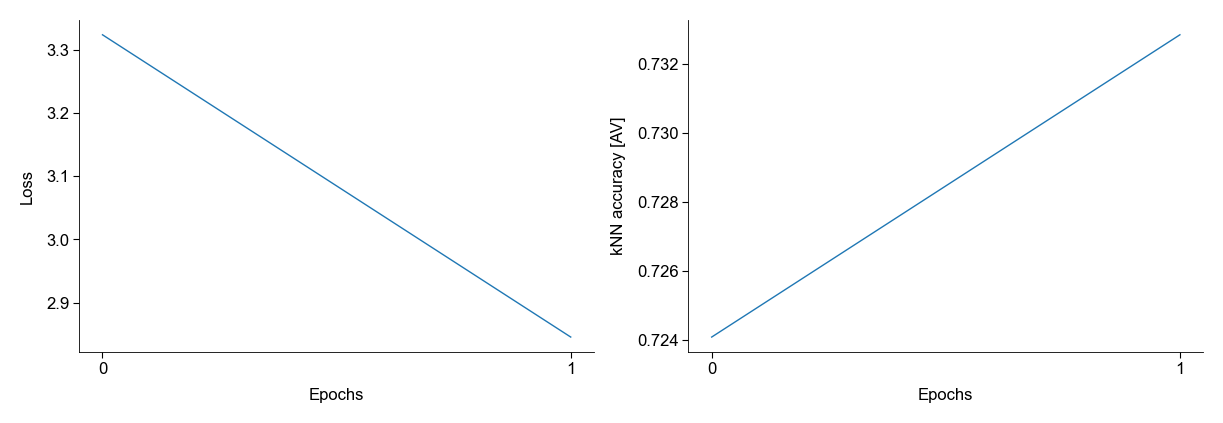

In [ ]:
%matplotlib inline
n_epochs = 2

fig, ax = plt.subplots(1, 2, figsize=(6, 2), dpi=200)

ax[0].plot(np.arange(n_epochs), np.mean(losses_2, axis=1))
ax[0].set_xticks(np.arange(n_epochs))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(np.arange(n_epochs), knn_accuracies_2[:, 0])
ax[1].set_xticks(np.arange(n_epochs))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("kNN accuracy [AV]")

In [ ]:
losses_1 == losses_2

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

In [ ]:
knn_accuracies_1 == knn_accuracies_2

array([[ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
%%time
losses_3, knn_accuracies_3 = train_loop(
    model,
    training_loader,
    device,
    titles_abstracts_together,
    tokenizer,
    labeled,
    labels_acc=iclr_labeled["y"].to_numpy(),
    n_epochs=2,
    lr=2e-5,
)

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
losses_2 == losses_3

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [ ]:
knn_accuracies_2 == knn_accuracies_3

array([[False, False, False],
       [False, False, False]])

# kNN accuracy before training for the new models
MPNet and SciBERT

In [ ]:
model_names_left = [
    "MPNet",
    "SciBERT",
]

model_paths_left = [
    "microsoft/mpnet-base",
    "allenai/scibert_scivocab_uncased",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names_left):
    # set up model
    print('Model: ', model_name)
    
    random_state = random.seed(42)
    device = (
        "cuda" if torch.cuda.is_available() else "cpu"
    )  
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths_left[i])
    model = AutoModel.from_pretrained(model_paths_left[i])
    print(model_paths_left[i])

    model = model.to(device)

    # get embeddings
    embedding_cls, embedding_sep, embedding_av = generate_embeddings(titles_abstracts_together, tokenizer, model, device, batch_size=256)

    # save embeddings
    saving_path = Path("embeddings_" + model_name.lower())
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path/saving_path/"embedding_cls", embedding_cls)
    np.save(variables_path/saving_path/"embedding_sep", embedding_sep)
    np.save(variables_path/saving_path/"embedding_av", embedding_av)
    
    model = None
    gc.collect()
    torch.cuda.empty_cache()

    print('----------------------------')



Model:  MPNet
Running on device: cuda


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

microsoft/mpnet-base


  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


allenai/scibert_scivocab_uncased


  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
%%time
%%memit
print("kNN accuracy     [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names_left):
    # print("Model: ", model_name)

    # import
    saving_path = Path("embeddings_" + model_name.lower())

    embedding_cls = np.load(variables_path / saving_path / "embedding_cls.npy")
    embedding_sep = np.load(variables_path / saving_path / "embedding_sep.npy")
    embedding_av = np.load(variables_path / saving_path / "embedding_av.npy")

    # print(type(embedding_av))

    # knn acc
    knn_acc = knn_accuracy(
        [
            embedding_av[labeled],
            embedding_cls[labeled],
            embedding_sep[labeled],
        ],
        iclr_labeled["y"].to_numpy(),
    )
    print(f"{model_name}: {np.array(knn_acc)*100}")

    # save embeddings
    saving_name = Path("knn_accuracy_" + model_name.lower())
    np.save(variables_path / saving_name, knn_acc)

    # print("----------------------------")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
kNN accuracy     [AVG]    [CLS]   [SEP]
MPNet: [54.30656934 53.13868613 49.48905109]
SciBERT: [63.35766423 36.64233577 35.91240876]
peak memory: 9187.06 MiB, increment: 5.19 MiB
CPU times: user 2min, sys: 5min 10s, total: 7min 10s
Wall time: 8.97 s


# All models

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

## Training run8
Optimize the [av] representation for 10 epochs for all models (with new models). batch_size=128, lr=2e-5.

Also evaluate the 7th token as a rep.


In [ ]:
model_names[3]

NameError: name 'model_names' is not defined

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    if i < 3:
        continue
    else:
        ## fix random seeds
        seed = 42
        # Set the random seed for PyTorch
        torch.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # torch.use_deterministic_algorithms(True)
        # Set the random seed for NumPy
        np.random.seed(seed)
        # Set the random seed
        random.seed(seed)

        # set up model
        print("Model: ", model_name)

        device = "cuda" if torch.cuda.is_available() else "cpu"
        print("Running on device: {}".format(device))

        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoModel.from_pretrained(model_paths[i])
        print(model_paths[i])

        # data
        training_dataset = SentencePairDataset(
            iclr.abstract, tokenizer, device
        )
        gen = torch.Generator()
        gen.manual_seed(seed)
        training_loader = torch.utils.data.DataLoader(
            training_dataset, batch_size=128, shuffle=True, generator=gen
        )

        # training
        losses, knn_accuracies = train_loop(
            model,
            training_loader,
            device,
            titles_abstracts_together,
            tokenizer,
            labeled,
            iclr_labeled["y"].to_numpy(),
            optimized_rep="av",
            n_epochs=10,
            lr=2e-5,
            return_seventh=True,
        )

        # save
        saving_path = Path("embeddings_" + model_name.lower())
        (variables_path / saving_path).mkdir(exist_ok=True)

        np.save(variables_path / saving_path / "losses_run8", losses)
        np.save(
            variables_path / saving_path / "knn_accuracies_run8",
            knn_accuracies,
        )

        # clean up
        model = None
        tokenizer = None
        gc.collect()
        torch.cuda.empty_cache()

        print("----------------------------")

Model:  SciBERT
Running on device: cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


allenai/scibert_scivocab_uncased


  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### kNN accuracy before training for the 7th token

In [ ]:
%%time
knn_acc_7th_before_training = []
print("kNN accuracy     [7th]")
for i, model_name in enumerate(model_names):
    # set up model
    random_state = random.seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    # print(model_paths[i])

    model.to(device)

    _, _, _, embedding_7th = generate_embeddings(
        titles_abstracts_together,
        tokenizer,
        model,
        device,
        batch_size=256,
        return_seventh=True,
    )

    knn_acc = knn_accuracy(
        embedding_7th[labeled], iclr_labeled["y"].to_numpy()
    )
    knn_acc_7th_before_training.append(knn_acc)
    print(f"{model_name}: {knn_acc*100}")

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

kNN accuracy     [7th]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
np.save(
    variables_path / "knn_acc_7th_before_training_run8",
    knn_acc_7th_before_training,
)

In [ ]:
knn_acc_7th_before_training

[0.3927007299270073,
 0.3927007299270073,
 0.6817518248175183,
 0.3970802919708029,
 0.5693430656934306,
 0.6846715328467153]

### Plot

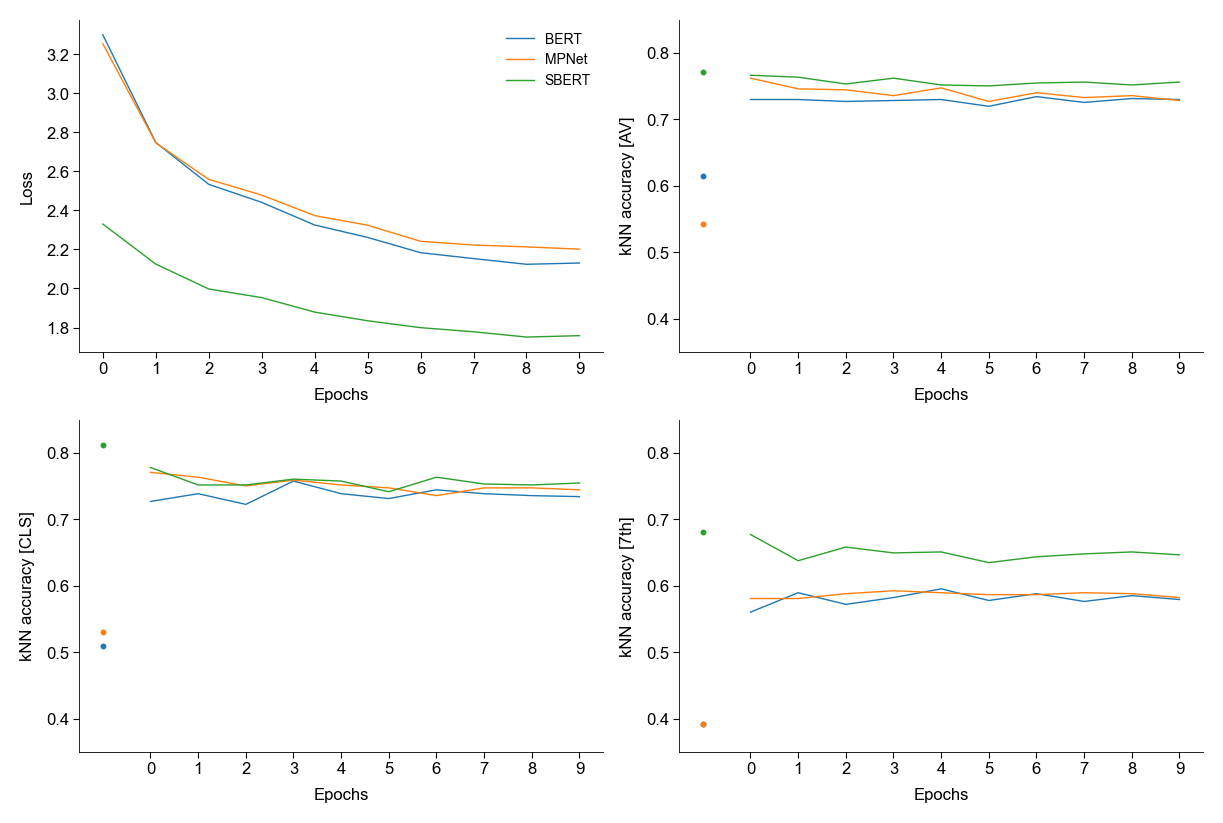

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")
for i in range(3):
    model_name = model_names[i]
    # load things
    saving_path = Path("embeddings_" + model_name.lower())

    losses = np.load(variables_path / saving_path / "losses_run8.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run8.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc_highd = np.load(variables_path / saving_name_2)

    knn_acc_7th_before_training = np.load(
        variables_path / "knn_acc_7th_before_training_run8.npy",
    )

    color = colormap(i)

    axs[0, 0].plot(
        np.arange(n_epochs), np.mean(losses, axis=1), label=model_name
    )
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    axs[0, 1].plot(np.arange(n_epochs), knn_accuracies[:, 0], label=model_name)
    axs[0, 1].scatter(-1, knn_acc_highd[0], c=color, s=5)
    axs[0, 1].set_xticks(np.arange(n_epochs))
    axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")

    axs[1, 0].plot(np.arange(n_epochs), knn_accuracies[:, 1], label=model_name)
    axs[1, 0].scatter(-1, knn_acc_highd[1], c=color, s=5)
    axs[1, 0].set_xticks(np.arange(n_epochs))
    axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")

    axs[1, 1].plot(np.arange(n_epochs), knn_accuracies[:, 3], label=model_name)
    axs[1, 1].scatter(-1, knn_acc_7th_before_training[i], c=color, s=5)
    axs[1, 1].set_xticks(np.arange(n_epochs))
    axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("kNN accuracy [7th]")

fig.savefig(figures_path / "loss_and_knn_accuracy_training_run8_pack1_v1.png")

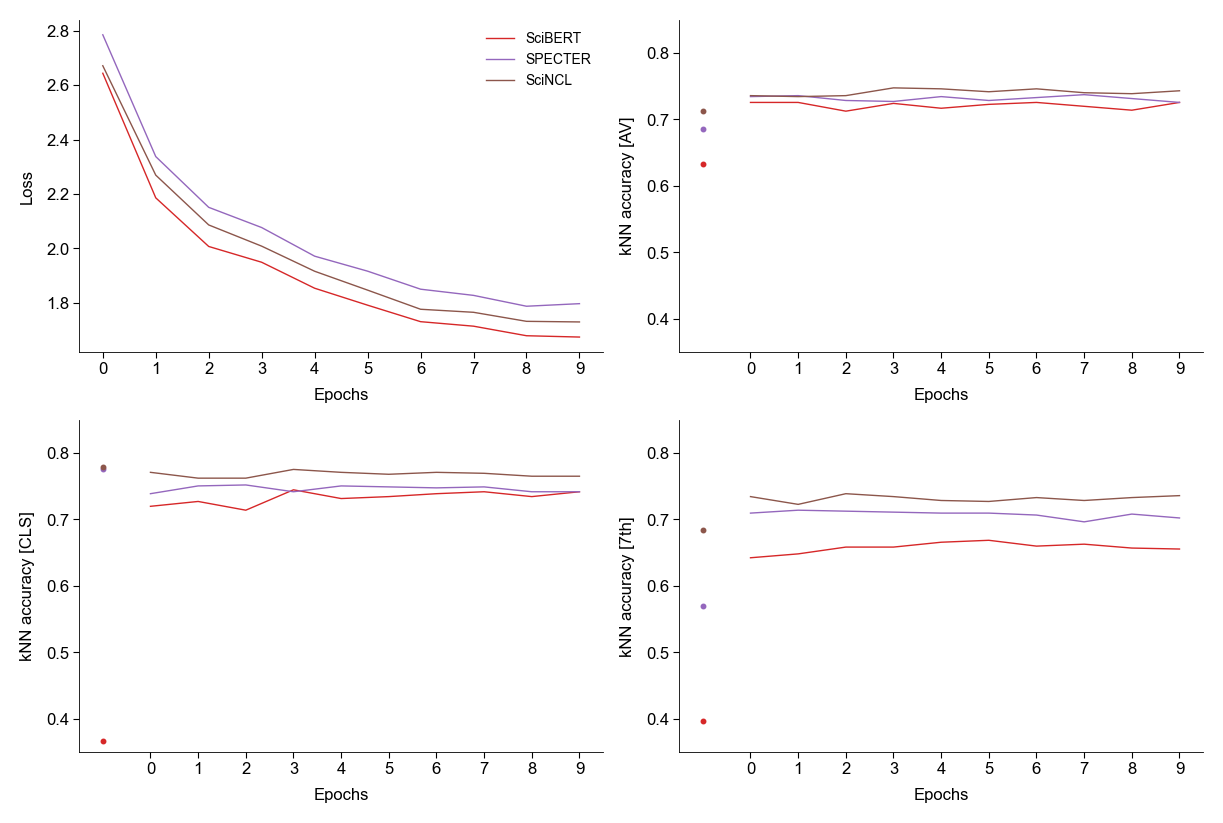

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i in range(3, len(model_names)):
    model_name = model_names[i]
    # load things
    saving_path = Path("embeddings_" + model_name.lower())

    losses = np.load(variables_path / saving_path / "losses_run8.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run8.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc_highd = np.load(variables_path / saving_name_2)

    knn_acc_7th_before_training = np.load(
        variables_path / "knn_acc_7th_before_training_run8.npy",
    )

    color = colormap(i)

    axs[0, 0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    axs[0, 1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=model_name,
        color=color,
    )
    axs[0, 1].scatter(-1, knn_acc_highd[0], c=color, s=5)
    axs[0, 1].set_xticks(np.arange(n_epochs))
    axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")

    axs[1, 0].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 1],
        label=model_name,
        color=color,
    )
    axs[1, 0].scatter(-1, knn_acc_highd[1], c=color, s=5)
    axs[1, 0].set_xticks(np.arange(n_epochs))
    axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")

    axs[1, 1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 3],
        label=model_name,
        color=color,
    )
    axs[1, 1].scatter(-1, knn_acc_7th_before_training[i], c=color, s=5)
    axs[1, 1].set_xticks(np.arange(n_epochs))
    axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("kNN accuracy [7th]")

fig.savefig(figures_path / "loss_and_knn_accuracy_training_run8_pack2_v1.png")

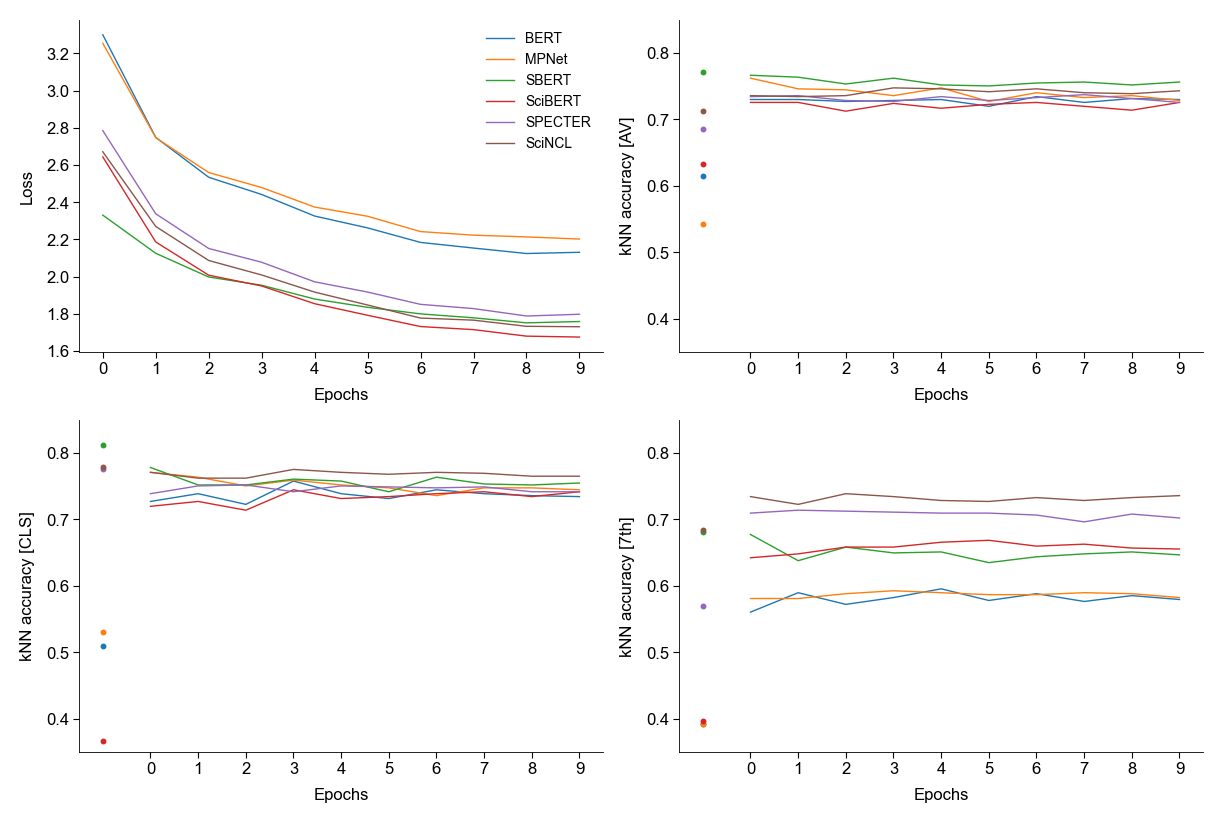

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower())

    losses = np.load(variables_path / saving_path / "losses_run8.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run8.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc_highd = np.load(variables_path / saving_name_2)

    knn_acc_7th_before_training = np.load(
        variables_path / "knn_acc_7th_before_training_run8.npy",
    )

    color = colormap(i)

    axs[0, 0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    axs[0, 1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=model_name,
        color=color,
    )
    axs[0, 1].scatter(-1, knn_acc_highd[0], c=color, s=5)
    axs[0, 1].set_xticks(np.arange(n_epochs))
    axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")

    axs[1, 0].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 1],
        label=model_name,
        color=color,
    )
    axs[1, 0].scatter(-1, knn_acc_highd[1], c=color, s=5)
    axs[1, 0].set_xticks(np.arange(n_epochs))
    axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")

    axs[1, 1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 3],
        label=model_name,
        color=color,
    )
    axs[1, 1].scatter(-1, knn_acc_7th_before_training[i], c=color, s=5)
    axs[1, 1].set_xticks(np.arange(n_epochs))
    axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("kNN accuracy [7th]")

fig.savefig(figures_path / "loss_and_knn_accuracy_training_run8_v1.png")

## Training run9
Optimize the [CLS] representation for 10 epochs for all models (with new models). batch_size=128, lr=2e-5.

Also evaluate the 7th token as a rep.


In [22]:
model_names[3]

'SciBERT'

In [23]:
%%time
for i, model_name in enumerate(model_names):
    if i < 3:
        continue
    else:
        ## fix random seeds
        seed = 42
        # Set the random seed for PyTorch
        torch.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # torch.use_deterministic_algorithms(True)
        # Set the random seed for NumPy
        np.random.seed(seed)
        # Set the random seed
        random.seed(seed)

        # set up model
        print("Model: ", model_name)

        device = "cuda" if torch.cuda.is_available() else "cpu"
        print("Running on device: {}".format(device))

        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoModel.from_pretrained(model_paths[i])
        print(model_paths[i])

        # data
        training_dataset = SentencePairDataset(
            iclr.abstract, tokenizer, device
        )
        gen = torch.Generator()
        gen.manual_seed(seed)
        training_loader = torch.utils.data.DataLoader(
            training_dataset, batch_size=128, shuffle=True, generator=gen
        )

        # training
        losses, knn_accuracies = train_loop(
            model,
            training_loader,
            device,
            titles_abstracts_together,
            tokenizer,
            labeled,
            iclr_labeled["y"].to_numpy(),
            optimized_rep="cls",
            n_epochs=10,
            lr=2e-5,
            return_seventh=True,
        )

        # save
        saving_path = Path("embeddings_" + model_name.lower())
        (variables_path / saving_path).mkdir(exist_ok=True)

        np.save(variables_path / saving_path / "losses_run9", losses)
        np.save(
            variables_path / saving_path / "knn_accuracies_run9",
            knn_accuracies,
        )

        # clean up
        model = None
        tokenizer = None
        gc.collect()
        torch.cuda.empty_cache()

        print("----------------------------")

Model:  SciBERT
Running on device: cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


allenai/scibert_scivocab_uncased


  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Plot

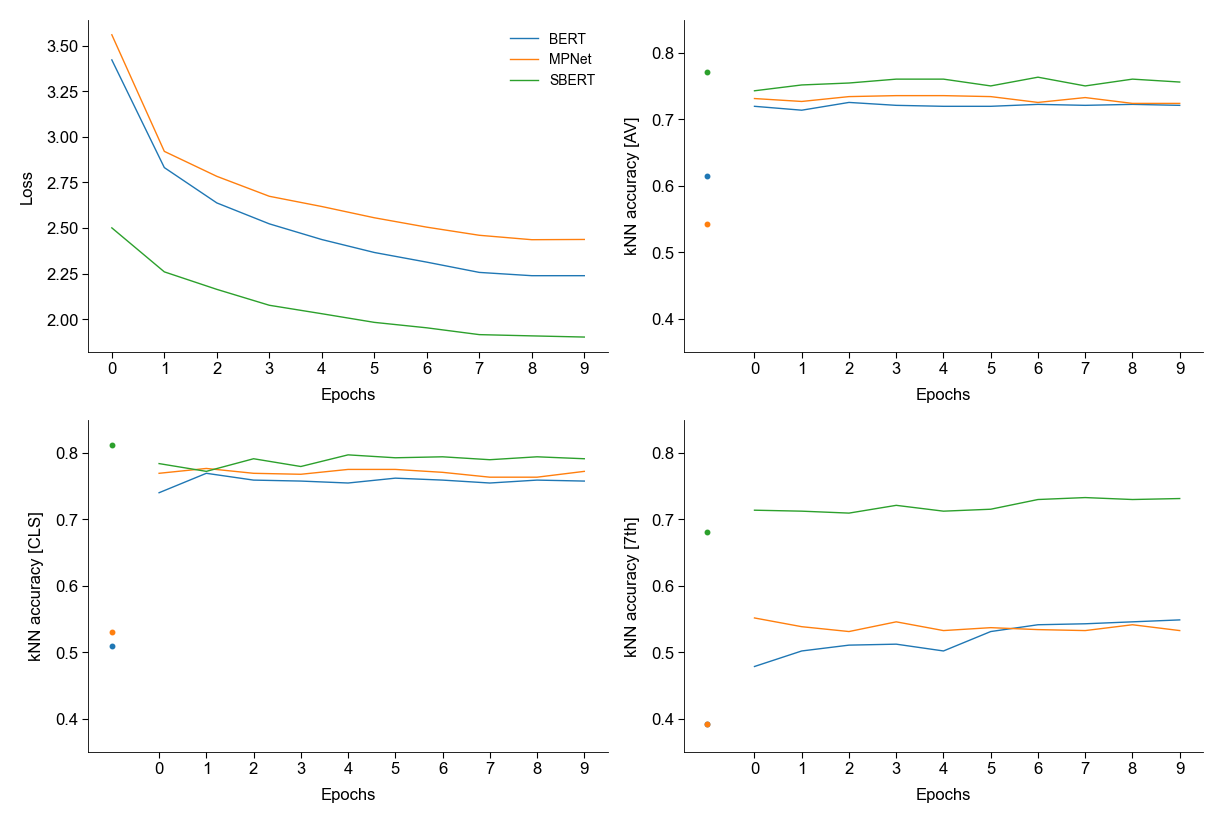

In [24]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")
for i in range(3):
    model_name = model_names[i]
    # load things
    saving_path = Path("embeddings_" + model_name.lower())

    losses = np.load(variables_path / saving_path / "losses_run9.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run9.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc_highd = np.load(variables_path / saving_name_2)

    knn_acc_7th_before_training = np.load(
        variables_path / "knn_acc_7th_before_training_run8.npy", #this one has to be run8
    )

    color = colormap(i)

    axs[0, 0].plot(
        np.arange(n_epochs), np.mean(losses, axis=1), label=model_name, color=color,
    )
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    axs[0, 1].plot(np.arange(n_epochs), knn_accuracies[:, 0], label=model_name, color=color)
    axs[0, 1].scatter(-1, knn_acc_highd[0], c=color, s=5)
    axs[0, 1].set_xticks(np.arange(n_epochs))
    axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")

    axs[1, 0].plot(np.arange(n_epochs), knn_accuracies[:, 1], label=model_name, color=color)
    axs[1, 0].scatter(-1, knn_acc_highd[1], c=color, s=5)
    axs[1, 0].set_xticks(np.arange(n_epochs))
    axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")

    axs[1, 1].plot(np.arange(n_epochs), knn_accuracies[:, 3], label=model_name, color=color)
    axs[1, 1].scatter(-1, knn_acc_7th_before_training[i], c=color, s=5)
    axs[1, 1].set_xticks(np.arange(n_epochs))
    axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("kNN accuracy [7th]")

fig.savefig(figures_path / "loss_and_knn_accuracy_training_run9_pack1_v1.png")

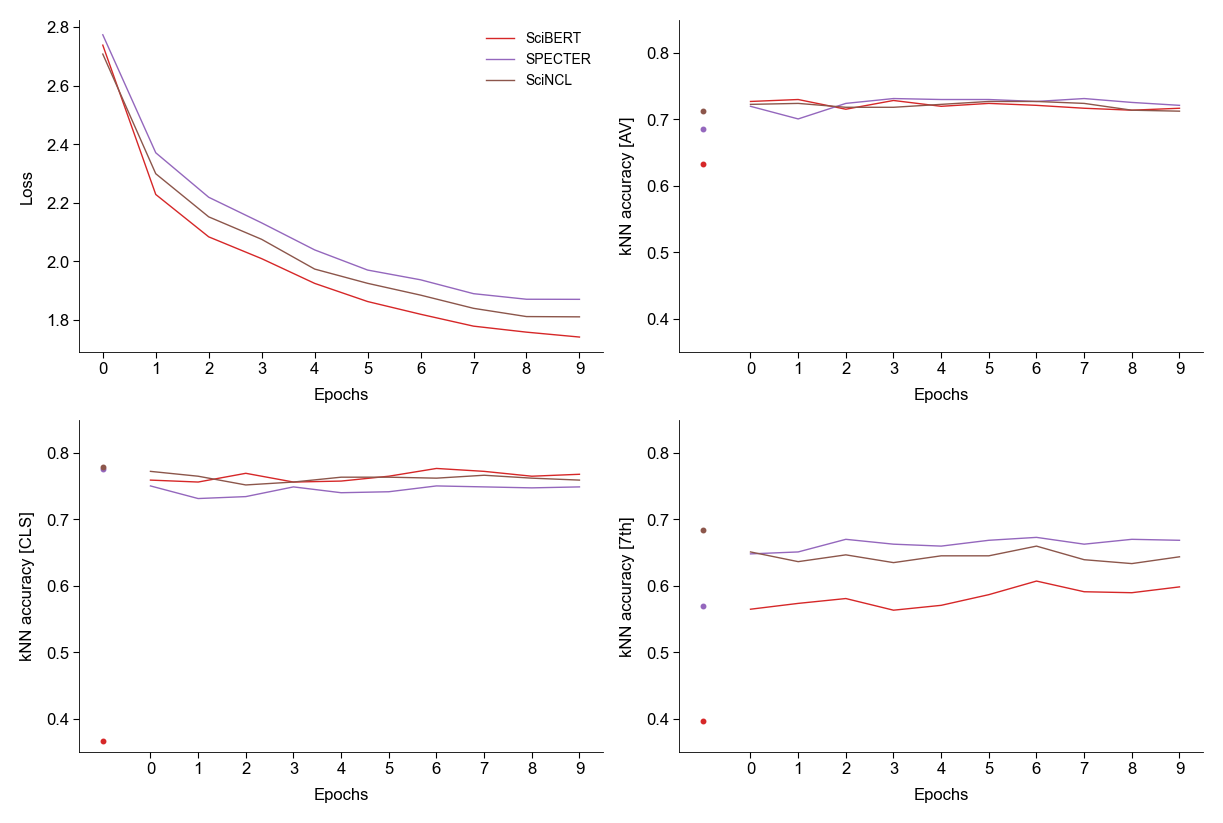

In [25]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i in range(3, len(model_names)):
    model_name = model_names[i]
    # load things
    saving_path = Path("embeddings_" + model_name.lower())

    losses = np.load(variables_path / saving_path / "losses_run9.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run9.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc_highd = np.load(variables_path / saving_name_2)

    knn_acc_7th_before_training = np.load(
        variables_path / "knn_acc_7th_before_training_run8.npy",
    )

    color = colormap(i)

    axs[0, 0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    axs[0, 1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=model_name,
        color=color,
    )
    axs[0, 1].scatter(-1, knn_acc_highd[0], c=color, s=5)
    axs[0, 1].set_xticks(np.arange(n_epochs))
    axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")

    axs[1, 0].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 1],
        label=model_name,
        color=color,
    )
    axs[1, 0].scatter(-1, knn_acc_highd[1], c=color, s=5)
    axs[1, 0].set_xticks(np.arange(n_epochs))
    axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")

    axs[1, 1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 3],
        label=model_name,
        color=color,
    )
    axs[1, 1].scatter(-1, knn_acc_7th_before_training[i], c=color, s=5)
    axs[1, 1].set_xticks(np.arange(n_epochs))
    axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("kNN accuracy [7th]")

fig.savefig(figures_path / "loss_and_knn_accuracy_training_run9_pack2_v1.png")

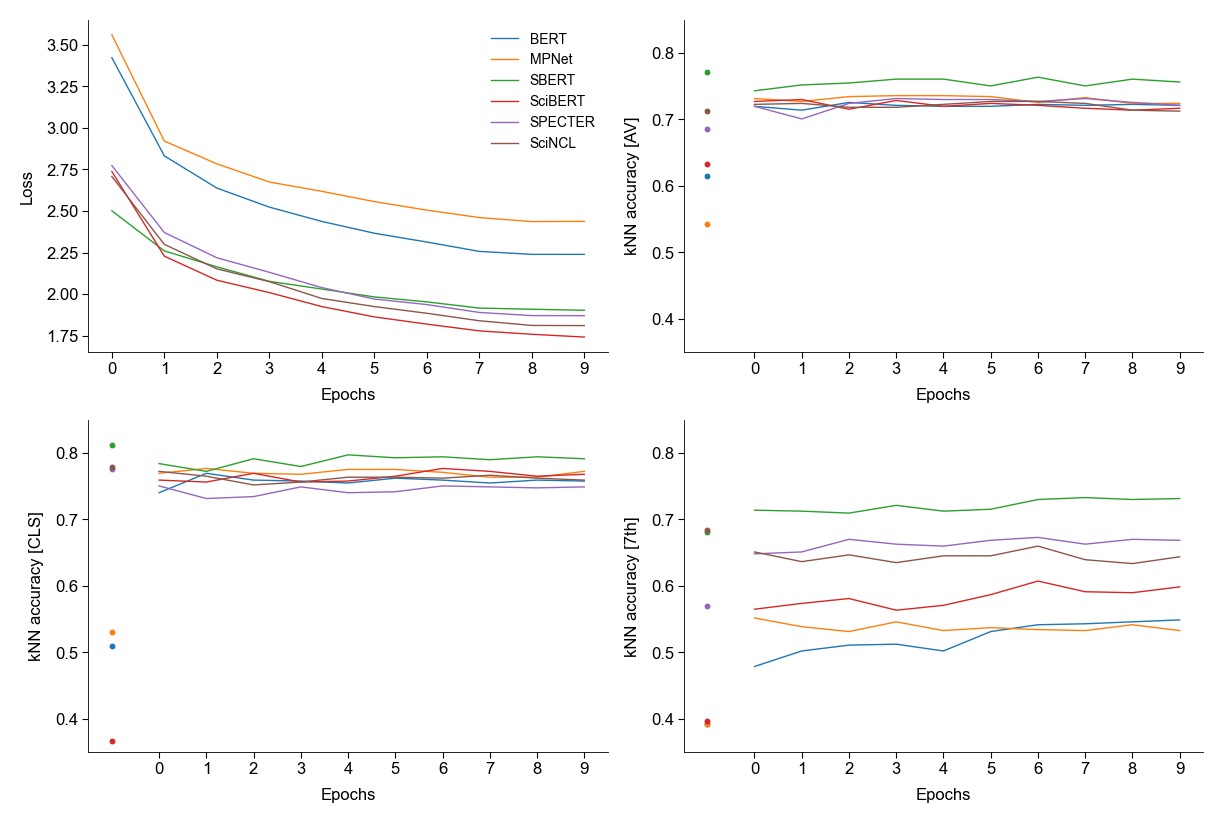

In [27]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower())

    losses = np.load(variables_path / saving_path / "losses_run9.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run9.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc_highd = np.load(variables_path / saving_name_2)

    knn_acc_7th_before_training = np.load(
        variables_path / "knn_acc_7th_before_training_run8.npy",
    )

    color = colormap(i)

    axs[0, 0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    axs[0, 1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=model_name,
        color=color,
    )
    axs[0, 1].scatter(-1, knn_acc_highd[0], c=color, s=5)
    axs[0, 1].set_xticks(np.arange(n_epochs))
    axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")

    axs[1, 0].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 1],
        label=model_name,
        color=color,
    )
    axs[1, 0].scatter(-1, knn_acc_highd[1], c=color, s=5)
    axs[1, 0].set_xticks(np.arange(n_epochs))
    axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")

    axs[1, 1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 3],
        label=model_name,
        color=color,
    )
    axs[1, 1].scatter(-1, knn_acc_7th_before_training[i], c=color, s=5)
    axs[1, 1].set_xticks(np.arange(n_epochs))
    axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("kNN accuracy [7th]")

fig.savefig(figures_path / "loss_and_knn_accuracy_training_run9_v1.png")